In [1]:
include(joinpath("..","src","setup.jl"))
using IntervalSets
using Unitful 
datadir = joinpath("..","data","count_lengths","run_2018-11-26")
params = load_params(joinpath(datadir,"params.jld2"))
params[:pindex] = 1:size(params,1)

┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/davidlittle/.julia/packages/Compose/BYWXX/src/Compose.jl:161
┌ Warning: Package Compose does not have Cairo in its dependencies:
│ - If you have Compose checked out for development and have
│   added Cairo as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Compose
│ Loading Cairo into Compose from project dependency, future warnings for Compose are suppressed.
└ @ nothing nothing:840
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/mapping.jl:228


1:900

In [2]:
settings = TOML.parsefile(joinpath("..","src","settings.toml"))
settings["track"]["analyze"]["source_prior_sds"] = [0.8]

1-element Array{Float64,1}:
 0.8

In [3]:
# make sure all types are loaded
p = copy(params[select_params(params,t_c_a=130,t_c_m=15,Δf=6),:])
run1 = bistable_model(p,settings,intermediate_results=true);

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43
Internal error: encountered unexpected error in runtime:
BoundsError(a=Array{Core.Compiler.NewNode, (0,)}[], i=(1,))
rec_backtrace at /Users/osx/buildbot/slave/package_osx64/build/src/stackwalk.c:94
record_backtrace at /Users/osx/buildbot/slave/package_osx64/build/src/task.c:246 [inlined]
jl_throw at /Users/osx/buildbot/slave/package_osx64/build/src/task.c:577
jl_bounds_error_ints at /Users/osx/buildbot/slave/package_osx64/build/src/rtutils.c:187
getindex at ./array.jl:731 [inlined]
getindex at ./compiler/ssair/ir.jl:677 [inlined]
abstract_eval_ssavalue at ./compiler/ssair/queries.jl:54 [inlined]
argextype at ./compiler/utilities.jl:181
is_known_call at ./compiler/optimize.jl:400 [inlined]
is_known_call at ./compiler/optimize.jl:397 [inlined]
is_tuple_call at ./compiler/ssair/queries.jl:70 [inlined]
lift_leaves at ./compiler/ssair/passes.jl:

┌ Warning: RCall.jl: Scale for 'fill' is already present. Adding another scale for 'fill', which
│ will replace the existing scale.
└ @ RCall /Users/davidlittle/.julia/packages/RCall/Q4n8R/src/io.jl:110


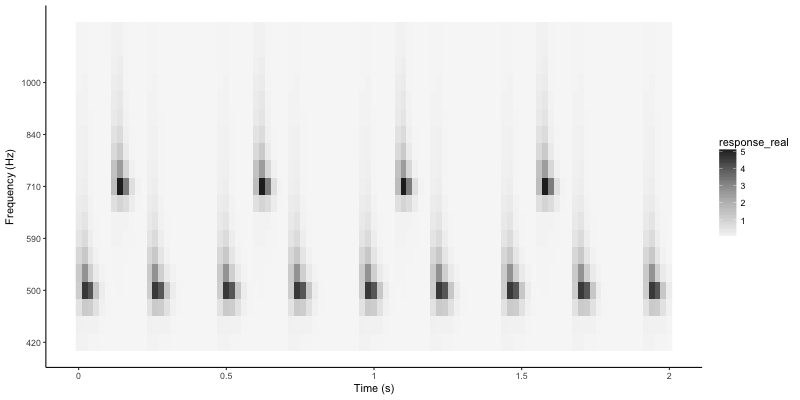

RObject{VecSxp}


In [65]:
pl = rplot(run1.spect.result[slice,400Hz .. 1200Hz]) 
pl = R"""
pl = $pl + scale_fill_distiller(palette="Greys",direction=1) + 
    theme_classic() + scale_x_continuous(labels=c(0,0.5,1.0,1.5,2.0),breaks=$(ustrip(minimum(slice))) + c(0,0.5,1,1.5,2.0))
ggsave($(joinpath(plotdir,"fig2a.pdf")),width=3.5,height=1.5)
pl
"""

pl

In [69]:
if !isfile("figure2_run.jld2")
    @save "figure2_run.jlds" run1 start_time stop_time
else
    @load "figure2_run.jld2" run1 start_time stop_time
    slice = start_time*s .. stop_time*s
end

┌ Warning: RCall.jl: Scale for 'fill' is already present. Adding another scale for 'fill', which
│ will replace the existing scale.
└ @ RCall /Users/davidlittle/.julia/packages/RCall/RPlFw/src/io.jl:110


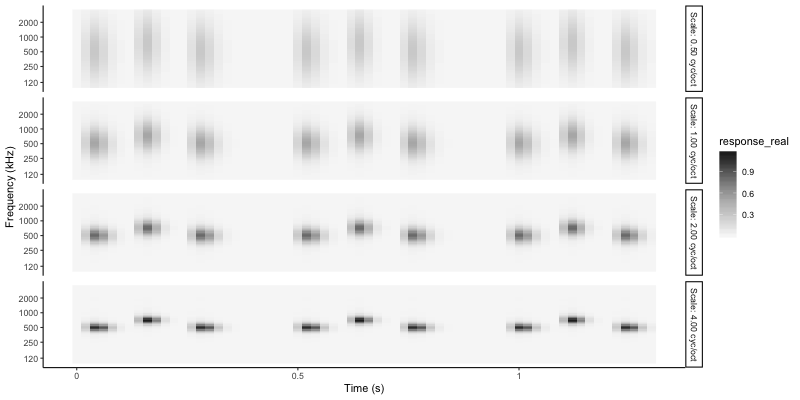

RObject{VecSxp}


In [7]:
cort = run1.cortical.result[slice]
absc = similar(cort,AxisArrays.axes(cort)...)
absc .= abs.(cort)
pl = rplot(absc)
pl = R"""
pl = $pl + scale_fill_distiller(palette="Greys",direction=1) + 
    theme_classic() + scale_x_continuous(labels=c(0,0.5,1.0,1.5),breaks=$(ustrip(minimum(slice))) + c(0,0.5,1,1.5))
ggsave($(joinpath(plotdir,"fig2b.pdf")),width=3.5,height=3)
pl
"""
pl

In [23]:
slice

12 s..13 s

┌ Warning: The following aesthetics are mapped, but not used by any geometry:
│ xgroup
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/Gadfly.jl:484
┌ Warning: The following aesthetics are mapped, but not used by any geometry:
│ xgroup
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/Gadfly.jl:484


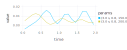

In [60]:
pldf,ax = asplotable(run1.sources.outweights[slice])
pldf.params = string.(pldf.params)
pldf.time .-= ustrip(minimum(slice))
pl = plot(pldf,x=:time,y=:value,xgroup=:params,color=:params,Geom.line,
    Guide.xticks(ticks=[0,0.5,1.0,1.5,2.0]),Guide.yticks(ticks=[0,0.01,0.02]))#,Coord.cartesian(xmax=1.36,ymin=-0.02))
draw(PDF(joinpath(plotdir,"fig2c_1.pdf"),4.5inch,2inch),pl)
draw(SVG(5inch,2inch),pl)

In [25]:
axisnames(run1.sources.tracks[2])

(:scale, :freq, :component, :time)

┌ Warning: RCall.jl: Scale for 'fill' is already present. Adding another scale for 'fill', which
│ will replace the existing scale.
└ @ RCall /Users/davidlittle/.julia/packages/RCall/Q4n8R/src/io.jl:110


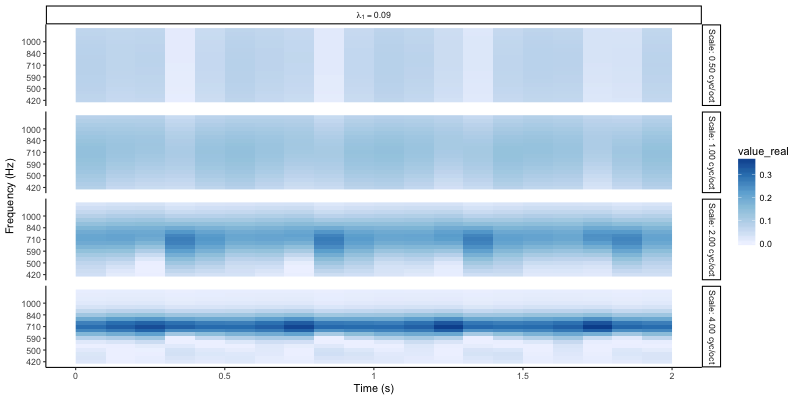

RObject{VecSxp}


In [62]:
tracks1 = run1.sources.tracks[1];

# to "find" the dominant source at each frame, we can just use the
# first source, since it is always the dominant one (rplot(tracks1) makes this clear)
pl = rplot(tracks1[:,:,1:1,slice])
pl = R"""
pl = $pl + scale_fill_distiller(palette="Blues",direction=1) + 
    theme_classic() + scale_x_continuous(labels=c(0,0.5,1.0,1.5,2.0),breaks=$(ustrip(minimum(slice))) + c(0,0.5,1,1.5,2.0))
ggsave($(joinpath(plotdir,"fig2c_2.pdf")),width=4,height=3)
pl
"""
pl

┌ Warning: RCall.jl: Scale for 'fill' is already present. Adding another scale for 'fill', which
│ will replace the existing scale.
└ @ RCall /Users/davidlittle/.julia/packages/RCall/Q4n8R/src/io.jl:110


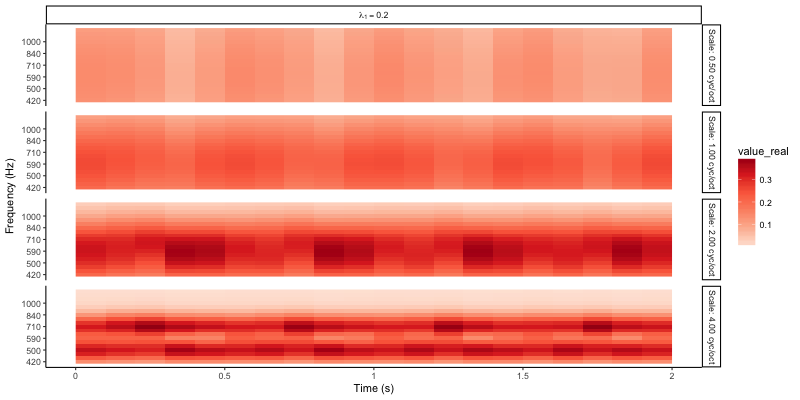

RObject{VecSxp}


In [63]:
tracks2 = run1.sources.tracks[2];

# to "find" the dominant source at each frame, we can just sum the frames for this source
# because of what rplot(tracks2) looks like (e.g. the dominant source alternates with an empty
# secondary source t random between the two source models)
vals .= tracks2[:,:,1:1,:] .+ tracks2[:,:,2:2,:]
pl = rplot(vals[:,:,1:1,slice])
pl = R"""
pl = $pl + scale_fill_distiller(palette="Reds",direction=1) + 
    theme_classic() + scale_x_continuous(labels=c(0,0.5,1.0,1.5,2.0),breaks=$(ustrip(minimum(slice))) + c(0,0.5,1,1.5,2.0))
ggsave($(joinpath(plotdir,"fig2c_3.pdf")),width=4,height=3)
pl
"""
pl

In [67]:
start_time = 12
stop_time = 14
slice = start_time*s .. stop_time*s

12 s..14 s

┌ Warning: RCall.jl: Scale for 'fill' is already present. Adding another scale for 'fill', which
│ will replace the existing scale.
└ @ RCall /Users/davidlittle/.julia/packages/RCall/Q4n8R/src/io.jl:110


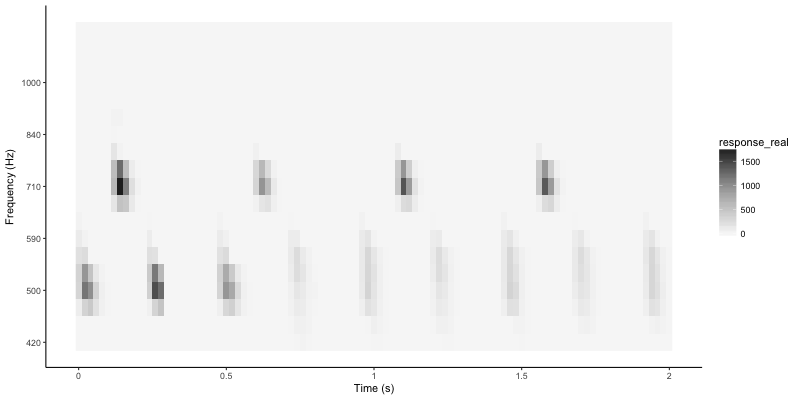

RObject{VecSxp}


In [57]:
pl = rplot(run1.primary_source[slice])
pl = R"""
pl = $pl + scale_fill_distiller(palette="Greys",direction=1) + 
    theme_classic() + scale_x_continuous(labels=c(0,0.5,1.0,1.5,2.0),breaks=$(ustrip(minimum(slice))) + c(0,0.5,1,1.5,2.0))
ggsave($(joinpath(plotdir,"fig2d.pdf")),width=3.5,height=1.5)
pl
"""
pl